In [1]:
from fastai.data.all import *
from fastai.vision.all import *
from fastbook import *

In [2]:
import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [3]:
import numpy as np

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cpu')

In [6]:
path = untar_data(URLs.MNIST_SAMPLE)

In [7]:
path.ls()

(#3) [Path('/Users/stephenzhou/.fastai/data/mnist_sample/valid'),Path('/Users/stephenzhou/.fastai/data/mnist_sample/labels.csv'),Path('/Users/stephenzhou/.fastai/data/mnist_sample/train')]

In [8]:
(path/'train').ls()

(#2) [Path('/Users/stephenzhou/.fastai/data/mnist_sample/train/7'),Path('/Users/stephenzhou/.fastai/data/mnist_sample/train/3')]

In [9]:
threes = sorted((path/'train/3').ls())

In [10]:
sevens = (path/'train/7').ls().sorted()

In [11]:
im3_path = threes[1]

In [12]:
im3 = Image.open(im3_path)

In [13]:
im3

In [14]:
array(im3).shape

(28, 28)

In [15]:
im3_t = tensor(im3)

In [16]:
df = pd.DataFrame(im3_t[4:15, 4:22])

In [17]:
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [18]:
tensors3 = [tensor(Image.open(o)) for o in threes]

In [19]:
tensors7 = [tensor(Image.open(o)) for o in sevens]

In [20]:
len(tensors3)

6131

In [21]:
len(tensors7)

6265

<Axes: >

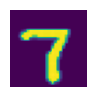

In [22]:
show_image(tensors7[0])

In [23]:
stacked_sevens = torch.stack(tensors7).float()/255

In [24]:
stacked_threes = torch.stack(tensors3).float()/255

In [25]:
stacked_threes.shape

torch.Size([6131, 28, 28])

In [26]:
mean3 = stacked_threes.mean(0)

<Axes: >

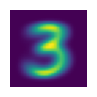

In [27]:
show_image(mean3)

In [28]:
mean7 = stacked_sevens.mean(0)

<Axes: >

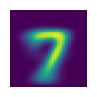

In [29]:
show_image(mean7)

In [30]:
def f(t, params):
    return params[0]*(t**2) + params[1]*t + params[2]

In [31]:
def mse(preds, targets):
    return torch.mean((preds - targets)**2)

In [32]:
params = torch.randn(3).requires_grad_()

In [33]:
params

tensor([0.3367, 0.1288, 0.2345], requires_grad=True)

In [34]:
time = torch.arange(20).float()

In [35]:
speed = torch.randn(20)*3 + 0.75 * (time - 9.5)**2 + 1

In [36]:
pred = f(time, params)

In [37]:
pred

tensor([  0.2345,   0.7000,   1.8388,   3.6511,   6.1367,   9.2958,  13.1282,  17.6340,  22.8131,  28.6657,  35.1916,  42.3909,  50.2636,  58.8097,  68.0291,  77.9219,  88.4881,  99.7277, 111.6407,
        124.2271], grad_fn=<AddBackward0>)

In [38]:
speed

tensor([74.0509, 53.7534, 42.4589, 29.8850, 20.3548, 16.4621,  3.2367,  5.0371, -1.4665, -1.4262,  0.5174,  7.8396,  3.9115,  9.9983, 13.7018, 24.6802, 28.0148, 46.1744, 52.5481, 66.8841])

In [39]:
def show_preds(preds, ax = None):
    if ax is None:
        ax = plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300, 100)

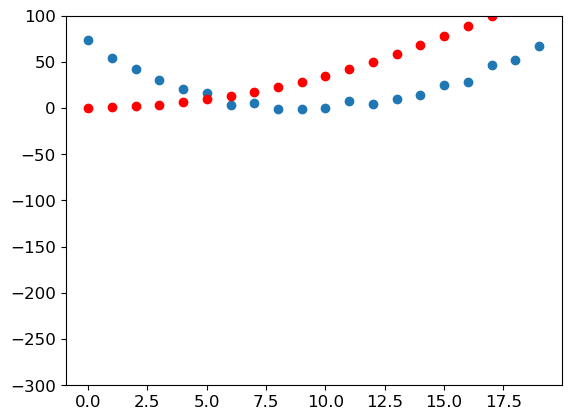

In [40]:
show_preds(pred)

In [41]:
loss = mse(pred, speed)

In [42]:
loss.backward()

In [43]:
params.grad

tensor([12011.0781,   781.4842,    36.4172])

In [44]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= 1e-5 * params.grad
    params.grad = None
    if prn:
        print(loss.item())
    return preds

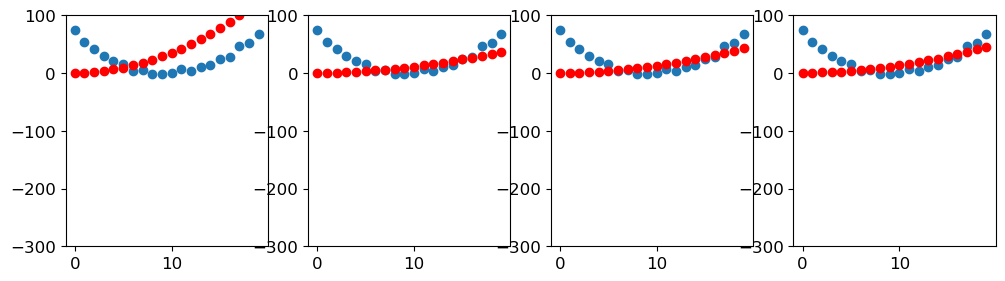

In [45]:
_, axes = plt.subplots(1,4,figsize=(12,3))
for ax in axes:
    show_preds(apply_step(params, False),ax)

In [46]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [47]:
train_x.shape

torch.Size([12396, 784])

In [48]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

In [49]:
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [50]:
dset = list(zip(train_x, train_y))

In [51]:
len(dset)

12396

In [52]:
x, y = dset[0]

In [53]:
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [54]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])

In [55]:
valid_3_tens = valid_3_tens.float()/255

In [56]:
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])

In [57]:
valid_7_tens = valid_7_tens.float()/255

In [58]:
valid_3_tens.shape

torch.Size([1010, 28, 28])

In [59]:
valid_7_tens.shape

torch.Size([1028, 28, 28])

In [60]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)

In [61]:
valid_y = tensor(len(valid_3_tens)*[1] + len(valid_7_tens)*[0]).unsqueeze(1)

In [62]:
valid_dset = list(zip(valid_x, valid_y))

In [63]:
valid_3_tens.shape

torch.Size([1010, 28, 28])

In [64]:
valid_7_tens.shape

torch.Size([1028, 28, 28])

In [65]:
valid_x.shape

torch.Size([2038, 784])

In [66]:
valid_y.shape

torch.Size([2038, 1])

In [67]:
len(valid_dset)

2038

In [68]:
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

In [69]:
weights = init_params((784,1))

In [70]:
bias = init_params(1)

In [71]:
(train_x[0]*weights.T).sum() + bias

tensor([19.7776], grad_fn=<AddBackward0>)

In [72]:
def linear1(xb):
    return xb@weights + bias

In [73]:
preds = linear1(train_x)

In [74]:
preds

tensor([[19.7776],
        [16.6084],
        [14.7824],
        ...,
        [17.9244],
        [23.4007],
        [28.2256]], grad_fn=<AddBackward0>)

In [75]:
corrects = (preds>0.5).float() == train_y

In [76]:
(corrects.sum()/len(corrects)).item()

0.4899161159992218

In [77]:
def mnist_loss(preds, targets):
    preds = preds.sigmoid()
    return torch.where(targets==1, 1-preds, preds).mean()

In [78]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

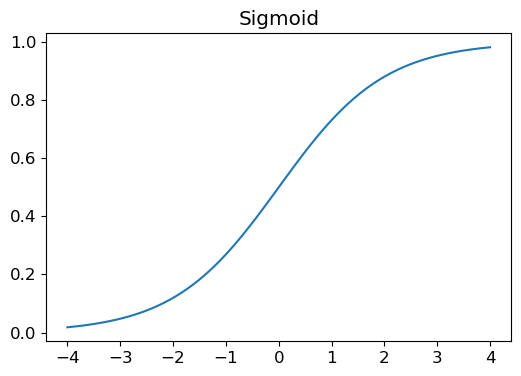

In [79]:
plot_function(torch.sigmoid, title = 'Sigmoid', min=-4, max=4)

In [80]:
coll = range(15)

In [81]:
dl = DataLoader(coll, batch_size = 5, shuffle=True)

In [82]:
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [83]:
ds = L(enumerate(string.ascii_lowercase))

In [84]:
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [85]:
len(ds)

26

In [86]:
dl = DataLoader(ds, batch_size=6, shuffle=True)

In [87]:
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

In [88]:
weights = init_params((28*28,1))

In [89]:
bias = init_params(1)

In [90]:
dl = DataLoader(dset, batch_size = 256)

In [91]:
xb, yb = first(dl)

In [92]:
xxb, yyb = list(dl)[0]

In [93]:
xxb.shape, yyb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [94]:
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [95]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [96]:
batch = train_x[:4]

In [97]:
batch.shape

torch.Size([4, 784])

In [98]:
torch.Size([4, 784])

torch.Size([4, 784])

In [99]:
train_x.shape

torch.Size([12396, 784])

In [100]:
preds = linear1(batch)

In [101]:
preds

tensor([[-2.1876],
        [-8.3973],
        [ 2.5000],
        [-4.9473]], grad_fn=<AddBackward0>)

In [102]:
loss = mnist_loss(preds, train_y[:4])

In [103]:
loss.backward()

In [104]:
loss.data.item()

0.7419267892837524

In [105]:
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0061), tensor([-0.0420]))

In [106]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()
    return loss.data.item()

In [107]:
calc_grad(batch, train_y[:4], linear1)

0.7419267892837524

In [108]:
weights.grad.mean(), bias.grad

(tensor(-0.0121), tensor([-0.0840]))

In [109]:
calc_grad(batch, train_y[:4], linear1)

0.7419267892837524

In [110]:
weights.grad.mean(), bias.grad

(tensor(-0.0182), tensor([-0.1260]))

In [111]:
weights.grad.zero_()

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [112]:
bias.grad.zero_()

tensor([0.])

In [113]:
def train_epoch(model, lr, params):
    losses = []
    for xb, yb in dl:
        losses.append(calc_grad(xb, yb, model))
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()
    return losses

In [114]:
(preds>0.5).float() == train_y[:4]

tensor([[False],
        [False],
        [ True],
        [False]])

In [115]:
def batch_accuracy(xb,yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()
    

In [116]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.2500)

In [117]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [118]:
validate_epoch(linear1)

0.5264

In [119]:
lr = 5

In [120]:
bias.grad.zero_()

tensor([0.])

In [121]:
weights.grad.zero_();

In [122]:
params = weights, bias

In [123]:
losses = train_epoch(linear1, lr, params)

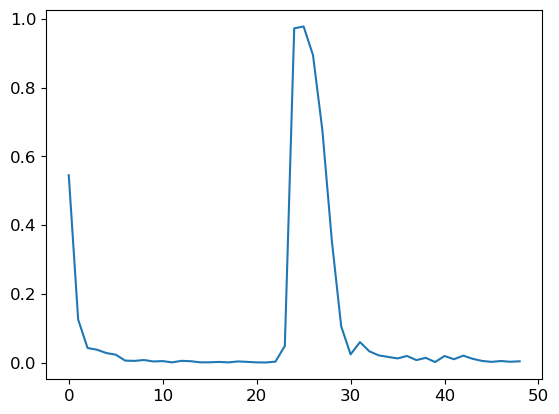

In [124]:
plt.plot(np.array(losses))

In [125]:
validate_epoch(linear1)

0.5512

In [126]:
weights = init_params((28*28,1))
bias = init_params(1)

In [127]:
params = weights,bias

In [129]:
avg_losses = []
for i in range(20):
    loss = train_epoch(linear1, lr, params)
    avg_losses.append(np.mean(loss))
    print(validate_epoch(linear1), end = ' ')

0.8657 0.9252 0.9384 0.9477 0.9545 0.9579 0.9604 0.9628 0.9677 0.9687 0.9696 0.9711 0.9721 0.9735 0.9755 0.977 0.9775 0.977 0.977 0.977 

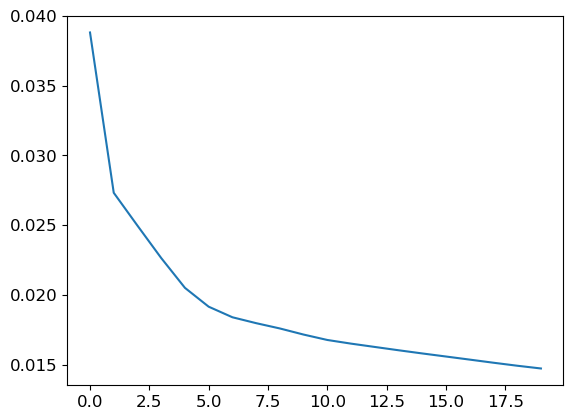

In [131]:
plt.plot(avg_losses)